# Experiment 1: Reconstruction Quality Comparison

This notebook compares the reconstruction quality of all three models:
1. **Baseline VAE** - No temporal modeling
2. **LSTM-VAE** - Unified latent space with LSTM
3. **Disentangled VAE** - Separate content and motion encoders

## Metrics
- MSE (Mean Squared Error)
- PSNR (Peak Signal-to-Noise Ratio)
- SSIM (Structural Similarity Index)
- Temporal Consistency


In [15]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from data import get_moving_mnist_dataloaders
from models import BaselineVAE, LSTMVAE, DisentangledVAE
from evaluation import reconstruction_metrics, compare_models, print_comparison_table
from utils import plot_reconstruction_comparison, plot_multiple_reconstructions, plot_video_frames

# Set device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")


Using device: mps


## 1. Load Data


In [16]:
# Create dataloaders
train_loader, val_loader, test_loader = get_moving_mnist_dataloaders(
    batch_size=32,
    train_size=10000,
    val_size=1000,
    test_size=1000,
    num_workers=4,
    seed=42
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 313
Val batches: 32
Test batches: 32


Video batch shape: torch.Size([32, 20, 1, 64, 64])


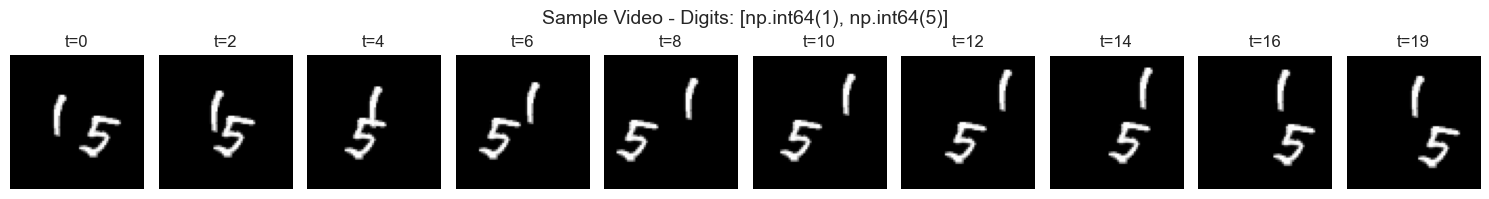

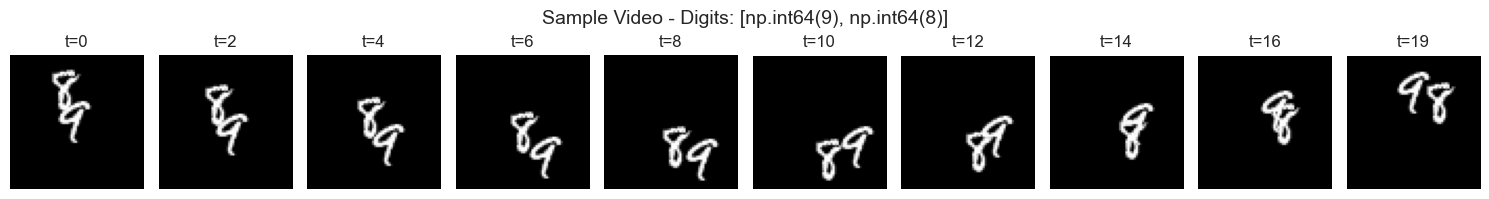

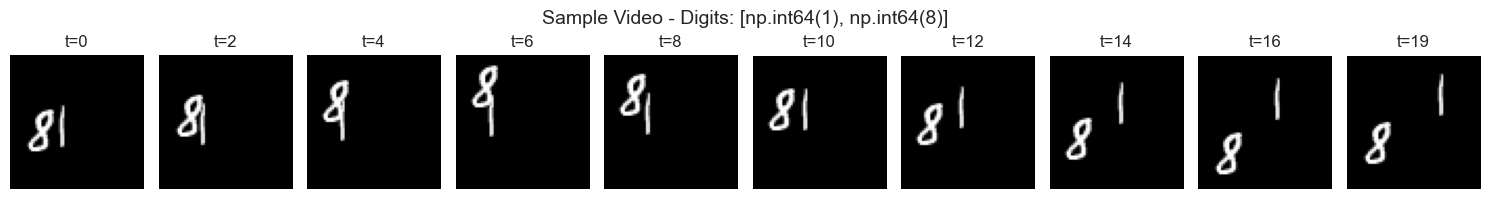

In [17]:
# Visualize sample videos
sample_video, sample_meta = next(iter(train_loader))
print(f"Video batch shape: {sample_video.shape}")

for i in range(min(3, sample_video.shape[0])):
    labels = sample_meta[i]['labels']
    fig = plot_video_frames(
        sample_video[i:i+1],
        num_frames=10,
        title=f"Sample Video - Digits: {labels}"
    )
    fig.savefig(f'../results/figures/sample_video_{i}.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)


## 2. Load or Train Models


In [18]:
# Initialize models
baseline_model = BaselineVAE(latent_dim=256).to(device)
lstm_model = LSTMVAE(latent_dim=256, lstm_hidden=256, lstm_layers=2, bidirectional=True).to(device)
disentangled_model = DisentangledVAE(content_dim=128, motion_dim=128, lstm_layers=1, bidirectional=True).to(device)

models = {
    'Baseline VAE': baseline_model,
    'LSTM-VAE': lstm_model,
    'Disentangled VAE': disentangled_model
}

# Print parameter counts
for name, model in models.items():
    params = sum(p.numel() for p in model.parameters())
    print(f"{name}: {params:,} parameters")


Baseline VAE: 4,791,681 parameters
LSTM-VAE: 10,441,857 parameters
Disentangled VAE: 12,934,625 parameters


In [19]:
# Try to load trained models
import os

checkpoint_paths = {
    'Baseline VAE': '../checkpoints/baseline_vae/best_model.pt',
    'LSTM-VAE': '../checkpoints/lstm_vae/best_model.pt',
    'Disentangled VAE': '../checkpoints/disentangled_vae/best_model.pt'
}

for name, path in checkpoint_paths.items():
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        models[name].load_state_dict(checkpoint['model_state_dict'])
        print(f"✓ Loaded {name} from checkpoint")
    else:
        print(f"✗ No checkpoint found for {name}")
        print(f"  Train with: python -m training.train --model {name.split()[0].lower()}")


✓ Loaded Baseline VAE from checkpoint
✓ Loaded LSTM-VAE from checkpoint
✓ Loaded Disentangled VAE from checkpoint


## 3. Compute Reconstruction Metrics


In [20]:
# Compute metrics for each model
results = compare_models(models, test_loader, device, max_batches=50)

# Print comparison table
print_comparison_table(results)



Evaluating Baseline VAE...


Evaluating: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]



Evaluating LSTM-VAE...


Evaluating: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]



Evaluating Disentangled VAE...


Evaluating: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]



MODEL COMPARISON
Metric              Baseline VAE        LSTM-VAE            Disentangled VAE    
--------------------------------------------------------------------------------
MSE ↓               0.033038            0.021601            0.020528            
PSNR ↑              14.81               16.66               16.88               
SSIM ↑              0.4559              0.7721              0.8337              
Temp. Cons.         0.000000            0.027418            0.043652            
Diversity           0.000650            0.012995            0.018819            
Parameters          4,791,681           10,441,857          12,934,625          
Forward (ms)        18.44               20.14               19.80               


## 4. Visual Comparison


Selected batch 10 for visualization
Video batch shape: torch.Size([32, 20, 1, 64, 64])


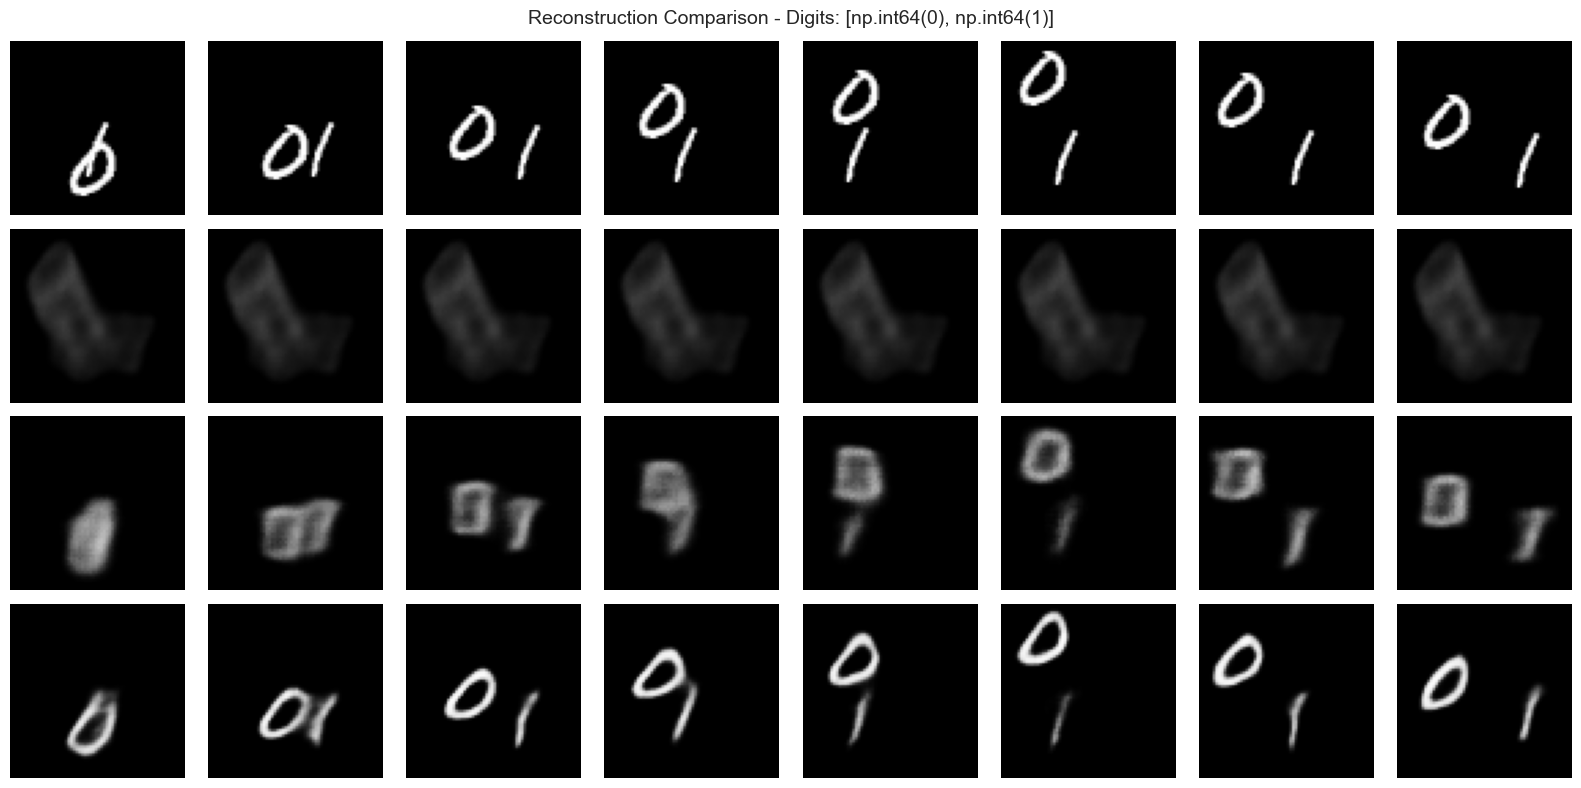

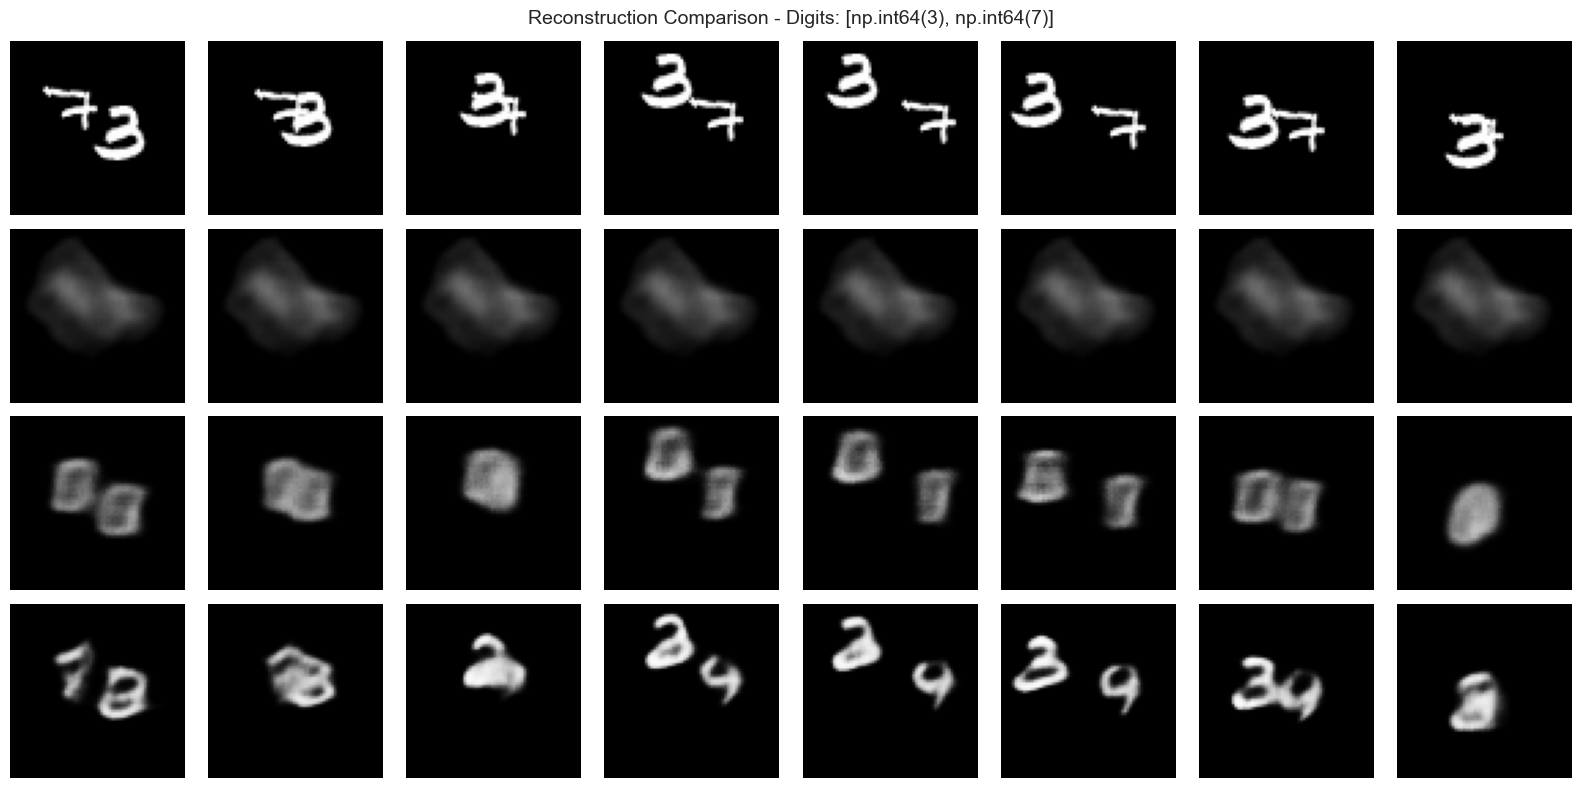

In [23]:
# Get random test samples for visualization
import random

# Randomly select a batch from test_loader
random_batch_idx = random.randint(0, len(test_loader) - 1)
for idx, (videos, metadata) in enumerate(test_loader):
    if idx == random_batch_idx:
        test_videos = videos.to(device)
        test_meta = metadata
        break

print(f"Selected batch {random_batch_idx} for visualization")
print(f"Video batch shape: {test_videos.shape}")

# Get reconstructions from each model
reconstructions = {}
for name, model in models.items():
    model.eval()
    with torch.no_grad():
        if name == 'Disentangled VAE':
            output = model(test_videos)
            reconstructions[name] = output['recon']
        else:
            recon, _, _, _ = model(test_videos)
            reconstructions[name] = recon

# Compare reconstructions
for i in range(min(2, test_videos.shape[0])):
    labels = test_meta[i]['labels']
    fig = plot_multiple_reconstructions(
        [test_videos[i:i+1]] * 3,
        [reconstructions[name][i:i+1] for name in models.keys()],
        model_names=list(models.keys()),
        title=f'Reconstruction Comparison - Digits: {labels}',
        num_frames=8
    )
    fig.savefig(f'../results/figures/reconstruction_comparison_{i+1}.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)


## Summary

### Expected Findings:
1. **Baseline VAE** should have the worst reconstruction quality due to lack of temporal modeling
2. **LSTM-VAE** should have good reconstruction quality with smooth temporal transitions
3. **Disentangled VAE** may have slightly lower reconstruction quality but provides disentanglement benefits

### Key Insights:
- Temporal modeling (LSTM) significantly improves video reconstruction
- The disentanglement approach trades off some reconstruction quality for controllability
- Frame-by-frame error analysis reveals where each model struggles
